# Loading ratings data

In [4]:
import pandas as pd

ratings_df = pd.read_csv('./data/ratings.dat', sep='::', header=None, engine='python')

ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
user_rating_df = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating')
norm_user_rating_df = user_rating_df.fillna(0)/5.0

norm_user_rating_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.8,0.0,0.8,0.0,0.6,0.0,0.0,0.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Preprocessing

In [6]:
import tensorflow as tf

train_x, test_x = tf.split(norm_user_rating_df.to_numpy().astype('float32'), 2)

train_dataset = tf.data.Dataset.from_tensor_slices(train_x)
train_dataset = train_dataset.shuffle(buffer_size=3020).batch(20)

test_dataset = tf.data.Dataset.from_tensor_slices(test_x)
test_dataset = test_dataset.shuffle(buffer_size=3020).batch(20)

# Training

In [7]:
from rbm import RBM
import numpy as np

epochs = 12
alpha = 0.01

model = RBM(len(user_rating_df.columns), 128)

def run(dataset, train=True):
    mean_cost = []
    for _, batch in enumerate(dataset):
        cost = model.train(batch, alpha) if train else model.evaluate(batch)
        mean_cost.append(cost)

    return np.mean(mean_cost)

End of epoch 0 with loss 0.19449492
End of epoch 1 with loss 0.11575676
End of epoch 2 with loss 0.08933978
End of epoch 3 with loss 0.07781671
End of epoch 4 with loss 0.070120275
End of epoch 5 with loss 0.06479771
End of epoch 6 with loss 0.06027401
End of epoch 7 with loss 0.05641159
End of epoch 8 with loss 0.053651758
End of epoch 9 with loss 0.05126497
End of epoch 10 with loss 0.04921036
End of epoch 11 with loss 0.04757076


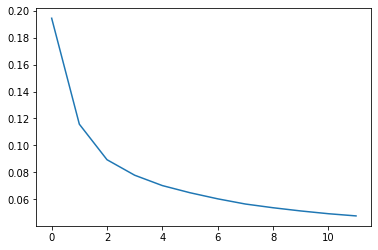

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt

progress = []
for epoch in range(epochs):
    loss = run(train_dataset)
    progress.append(loss)
    print('End of epoch %d with loss %s' % (epoch, loss))

plt.plot(progress)

# Evaluation

In [9]:
print('Evaluation loss %s' % (run(test_dataset, train=False)))

Evaluation loss 0.054450527


In [10]:
movies_df = pd.read_csv('./data/movies.dat', sep='::', header=None, engine='python')
movies_df.columns = ['MovieID', 'Title', 'Genres']

movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


# Recommending movies to a user

In [18]:
# Test the model with a mock case
mock_user_id = 176

inputUser = tf.reshape(train_x[mock_user_id - 1], (1, -1))
recommended = model.predict(inputUser)

prob, _ = recommended

## Listing all movies recommonded

In [19]:
rec_movies_df_mock = movies_df[movies_df['MovieID'].isin(user_rating_df.columns)]
rec_movies_df_mock = rec_movies_df_mock.assign(RecommendationScore = prob[0])

rec_movies_df_mock.head()

,MovieID,Title,Genres,RecommendationScore
0,1,Toy Story (1995),Animation|Children's|Comedy,0.043092
1,2,Jumanji (1995),Adventure|Children's|Fantasy,0.012430
2,3,Grumpier Old Men (1995),Comedy|Romance,0.093081
3,4,Waiting to Exhale (1995),Comedy|Drama,0.002351
4,5,Father of the Bride Part II (1995),Comedy,0.021264


## Sorting by most recommended movies

In [20]:
scored_movies_df_mock.sort_values(["RecommendationScore"], ascending=False).head()

,MovieID,Title,Genres,RecommendationScore
2849,2918,Ferris Bueller's Day Off (1986),Comedy,0.990191
3483,3552,Caddyshack (1980),Comedy,0.983484
1250,1270,Back to the Future (1985),Comedy|Sci-Fi,0.980079
2401,2470,Crocodile Dundee (1986),Adventure|Comedy,0.971087
1287,1307,When Harry Met Sally... (1989),Comedy|Romance,0.957077
